<a href="https://colab.research.google.com/github/Swagat-modder/Zeotap/blob/main/Swagat_Garadia_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc

In [2]:
# Load datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

In [3]:
# Merging datasets on CustomerID
merged_data = pd.merge(transactions, customers, on='CustomerID')

**Feature Engineering**

In [4]:
# Total spending per customer
customer_spending = merged_data.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_spending.rename(columns={'TotalValue': 'TotalSpending'}, inplace=True)

In [5]:
# Average transaction value per customer
customer_avg_value = merged_data.groupby('CustomerID')['TotalValue'].mean().reset_index()
customer_avg_value.rename(columns={'TotalValue': 'AvgTransactionValue'}, inplace=True)

In [6]:
# Number of transactions per customer
customer_transaction_count = merged_data.groupby('CustomerID')['TransactionID'].count().reset_index()
customer_transaction_count.rename(columns={'TransactionID': 'TransactionCount'}, inplace=True)

In [7]:
# Recency (days since last transaction)
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
last_transaction = merged_data.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_transaction.rename(columns={'TransactionDate': 'LastTransactionDate'}, inplace=True)
last_transaction['Recency'] = (pd.to_datetime('today') - last_transaction['LastTransactionDate']).dt.days

In [8]:
# Merging features
customer_features = pd.merge(customers, customer_spending, on='CustomerID')
customer_features = pd.merge(customer_features, customer_avg_value, on='CustomerID')
customer_features = pd.merge(customer_features, customer_transaction_count, on='CustomerID')
customer_features = pd.merge(customer_features, last_transaction[['CustomerID', 'Recency']], on='CustomerID')

In [9]:
# Encoding categorical features (e.g., Region)
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(customer_features[['Region']]).toarray()
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Region']))

In [10]:
# Combining features
final_features = pd.concat([customer_features.drop(['Region', 'CustomerName', 'SignupDate'], axis=1), encoded_df], axis=1)

In [11]:
# Normalizing numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(final_features.drop(columns=['CustomerID']))

**K-Means Clustering**

In [12]:
# Determining optimal number of clusters using the Elbow Method (for K-Means)
inertia = []
silhouette_scores_kmeans = []
calinski_harabasz_scores_kmeans = []
K = range(2, 11)  # Test 2 to 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores_kmeans.append(silhouette_score(scaled_features, kmeans.labels_))
    calinski_harabasz_scores_kmeans.append(calinski_harabasz_score(scaled_features, kmeans.labels_))

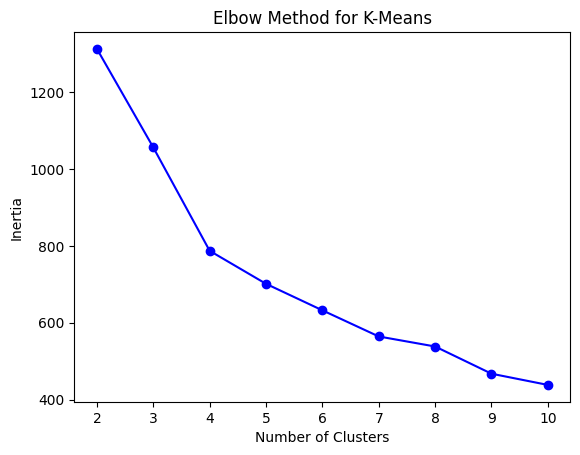

In [13]:
# Plotting Elbow Method
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')
plt.show()

In [14]:
# Choosing the optimal number of clusters (e.g., based on silhouette score)
optimal_clusters_kmeans = np.argmax(silhouette_scores_kmeans) + 2  # +2 because K starts from 2
print(f"Optimal number of clusters for K-Means: {optimal_clusters_kmeans}")

Optimal number of clusters for K-Means: 4


In [15]:
# Applying K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters_kmeans, random_state=42)
kmeans_clusters = kmeans.fit_predict(scaled_features)

In [16]:
# Evaluating K-Means clustering
db_index_kmeans = davies_bouldin_score(scaled_features, kmeans_clusters)
silhouette_avg_kmeans = silhouette_score(scaled_features, kmeans_clusters)
calinski_harabasz_kmeans = calinski_harabasz_score(scaled_features, kmeans_clusters)

In [17]:
print("K-Means Clustering Metrics:")
print(f"Davies-Bouldin Index: {db_index_kmeans}")
print(f"Silhouette Score: {silhouette_avg_kmeans}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_kmeans}")

K-Means Clustering Metrics:
Davies-Bouldin Index: 1.1014436134489514
Silhouette Score: 0.39579017297876856
Calinski-Harabasz Index: 66.47518227704981


**Hierarchical Clustering**

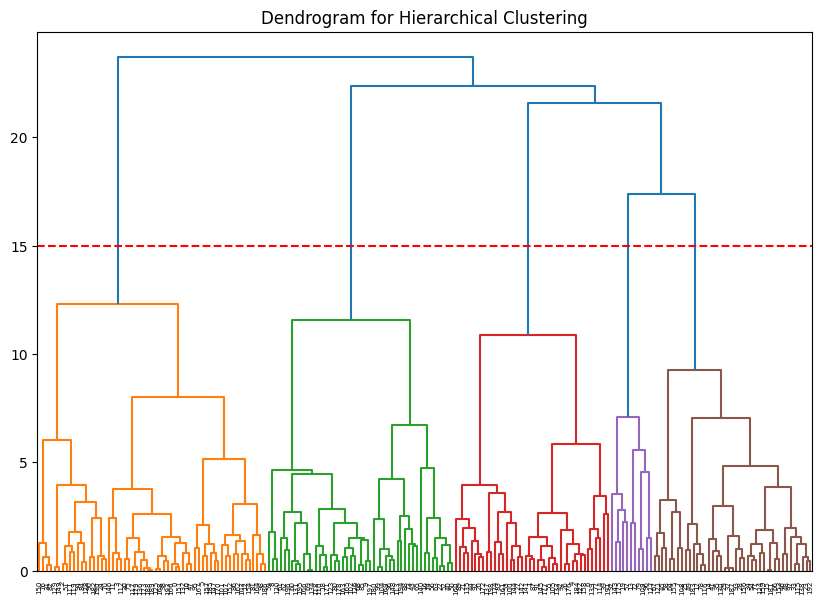

In [21]:
# Plotting Dendrogram to determine the optimal number of clusters
plt.figure(figsize=(10, 7))
plt.title("Dendrogram for Hierarchical Clustering")
dend = shc.dendrogram(shc.linkage(scaled_features, method='ward'))
plt.axhline(y=15, color='r', linestyle='--')  # Adjust the threshold based on the dendrogram
plt.show()

In [24]:
# Applying Agglomerative Clustering
optimal_clusters_hierarchical = 4  # Adjusting based on the dendrogram
hierarchical = AgglomerativeClustering(n_clusters=optimal_clusters_hierarchical, metric='euclidean', linkage='ward')
hierarchical_clusters = hierarchical.fit_predict(scaled_features)

In [25]:
# Evaluating Hierarchical Clustering
db_index_hierarchical = davies_bouldin_score(scaled_features, hierarchical_clusters)
silhouette_avg_hierarchical = silhouette_score(scaled_features, hierarchical_clusters)
calinski_harabasz_hierarchical = calinski_harabasz_score(scaled_features, hierarchical_clusters)

In [26]:
print("\nHierarchical Clustering Metrics:")
print(f"Davies-Bouldin Index: {db_index_hierarchical}")
print(f"Silhouette Score: {silhouette_avg_hierarchical}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_hierarchical}")


Hierarchical Clustering Metrics:
Davies-Bouldin Index: 1.2279653673839488
Silhouette Score: 0.3785388598288324
Calinski-Harabasz Index: 59.81772027056097


In [27]:
# Visualizing clusters using t-SNE for both methods
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)

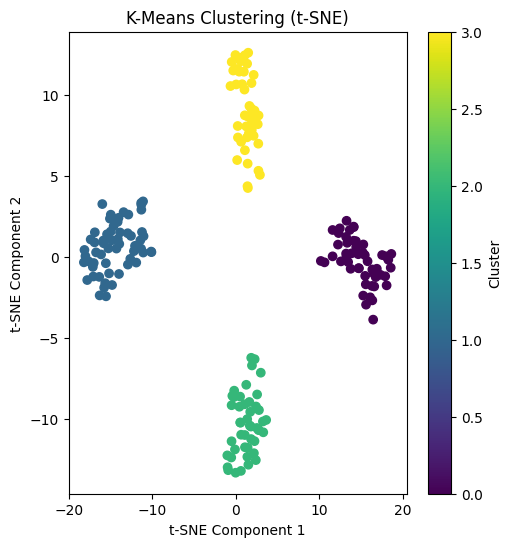

In [28]:
# Plotting K-Means clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=kmeans_clusters, cmap='viridis', marker='o')
plt.title('K-Means Clustering (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')

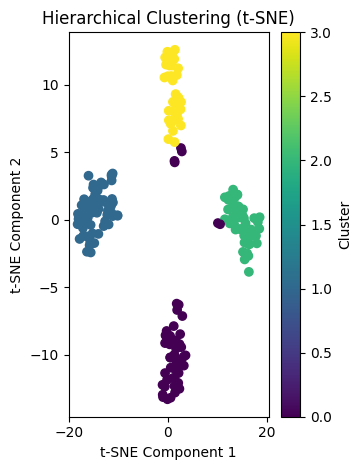

In [29]:
# Plotting Hierarchical clusters
plt.subplot(1, 2, 2)
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=hierarchical_clusters, cmap='viridis', marker='o')
plt.title('Hierarchical Clustering (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

In [ ]:
#Based on all three metrics, Hierarchical Clustering performs better than K-Means Clustering. Therefore, Hierarchical Clustering is the best choice according to the acquired metrics.